**Overview**
*   Get data
*   Visualize data and get to know it
*   Split data into test and train sets
*   Data preparation pipeline
    * Convert each email into a feature vector
    * Transform each word in the email into a sparse vector
*   Try out several classifiers to find the best classifier with high precision and high recall
*   Use various hyperparameter search algorithms and preformance metrics to tune algorithm

*I'll use the Bag of Words approach for my sparse feature vectors*

In [392]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from nltk.stem import PorterStemmer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score


%matplotlib inline

**Step 1: Get data**

In [393]:
data = pd.read_csv('./spam.csv', encoding="ISO-8859-1")

# need to encode to utf-8 to get rid of special characters
data['v2'].str.encode('utf-8')

# remove unneccesary columns
data = data[['v1', 'v2']]

**Step 2: Get to know data**

In [394]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [395]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


**Step 3: Train and Test sets**

In [396]:
train_set, test_set = train_test_split(data, test_size=0.1, random_state=42)

**Step 4: Data preparation**

*   Transform the labels into numbers using ordinal encoder

In [397]:

ordinal_encoder = OrdinalEncoder()

labels = data[['v1']]
labels_encoded = ordinal_encoder.fit_transform(labels)

print(labels_encoded[:10])
print(ordinal_encoder.categories_)

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]
[array(['ham', 'spam'], dtype=object)]


*   Clean up messages and stem

In [398]:

def process_email(email_contents):
    # lower case
    email_contents = email_contents.lower()
    
    # strip all HTML
    email_contents =re.compile('<[^<>]+>').sub(' ', email_contents)

    # handle Numbers
    email_contents = re.compile('[0-9]+').sub(' number ', email_contents)

    # handle URLS
    email_contents = re.compile('(http|https)://[^\s]*').sub(' httpaddr ', email_contents)

    # handle Email Addresses
    email_contents = re.compile('[^\s]+@[^\s]+').sub(' emailaddr ', email_contents)
    
    # handle $ sign
    email_contents = re.compile('[$]+').sub(' dollar ', email_contents)
    
    # get rid of any punctuation
    email_contents = re.split('[ @$/#.-:&*+=\[\]?!(){},''">_<;%\n\r]', email_contents)

    # remove any empty word string
    email_contents = [word for word in email_contents if len(word) > 0]

    # Stem the email contents word by word
    stemmer = PorterStemmer()

    processed_email = []
    
    for word in email_contents:
        # remove any remaining non alphanumeric characters in word
        word = re.compile('[^a-zA-Z0-9]').sub('', word).strip()
        word = stemmer.stem(word)
        processed_email.append(word)
    
    return processed_email

data_text = data['v2']

# examples
print('---------------Origonal Emails----------------')
print(data_text[:2])

print('\n-------------------New Emails-------------------')
for email in data_text[:2]:
    processed_email = process_email(email)
    print(processed_email)

# change actual values
data['v2'] = data['v2'].map(lambda e: process_email(e))

---------------Origonal Emails----------------
0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
Name: v2, dtype: object

-------------------New Emails-------------------
['go', 'until', 'jurong', 'point', 'crazi', 'avail', 'onli', 'in', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amor', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']


*   Now that we have the messages cleaned up as lists of words, our strategy is to make a list of all of the unique words in the emails and use it to make our sparse vectors of the messages

*   We will use the TF-IDF algorithm to get these weighted sparse vectors

In [399]:
# data_text is our corpus with each element in it as another document
data_text = data['v2'].map(lambda e: ' '.join(e))

# TF-IDF
vectorizer = TfidfVectorizer(max_features=2200)
tf_idf_vectors = vectorizer.fit_transform(data_text)


# now lets add the sparse vectors as our features, instead of the previous text
for i in range(len(vectorizer_names)):
    vector = pd.Series( [v[i] for v in tf_idf_vectors.toarray()] )
    data[vectorizer_names[i]] = vector


# we don't need the text anymore
data = data.drop('v2', axis=1)
data.head()



/var/folders/9h/frkggfjj1zj6532d3st4t5rr0000gn/T/ipykernel_13107/3243061116.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[vectorizer_names[i]] = vector


,v1,aathi,abi,abiola,abl,about,abt,ac,acc,accept,...,youd,youll,your,yourself,youv,yr,yun,yuo,yup,zed
0,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.360639,0.0,0.0,0.0,0.0


**Step 5: Put data together, train and test sets, try out classifiers**

In [400]:
data['v1'] = labels_encoded


train_set, test_set = train_test_split(data, test_size=0.1, random_state=42)

train_data = train_set.drop('v1', axis=1)
train_labels = train_set['v1']

test_data = test_set.drop('v1', axis=1)
test_labels = test_set['v1']

*   Naive Bayes

In [401]:
nb_clf = GaussianNB()
nb_clf.fit(train_data, train_labels)

# Predict Class
y_pred = nb_clf.predict(test_data)

# Accuracy 
accuracy = accuracy_score(test_labels, y_pred)

print(f'Accuracy: {np.round(accuracy*100, 2)}%')

print(f'F1 score: {f1_score(test_labels, y_pred)}')

Accuracy: 84.59%
F1 score: 0.5904761904761905


*   Logistic Regression

Accuracy: 98.39%
F1 score: 0.928


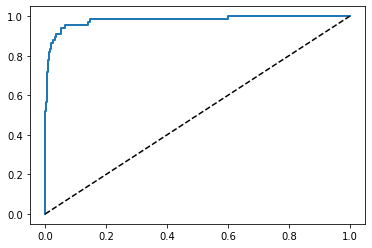

ROC AUC Score: 0.980150165668602


In [402]:
lr_clf = LogisticRegression()
lr_clf.fit(train_data, train_labels)

# Predict Class
y_pred = lr_clf.predict(test_data)

# Accuracy 
accuracy = accuracy_score(test_labels, y_pred)

print(f'Accuracy: {np.round(accuracy*100, 2)}%')

print(f'F1 score: {f1_score(test_labels, y_pred)}')

label_scores = cross_val_predict(lr_clf, test_data, test_labels, cv=3, method='decision_function')
fpr, tpr, thresholds = roc_curve(test_labels, label_scores)

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

print(f'ROC AUC Score: {roc_auc_score(test_labels, label_scores)}')

*   Random Forest

In [403]:
rfc_clf = RandomForestClassifier()
rfc_clf.fit(train_data, train_labels)

# Predict Class
y_pred = rfc_clf.predict(test_data)

# Accuracy 
accuracy = accuracy_score(test_labels, y_pred)

print(f'Accuracy: {np.round(accuracy*100, 2)}%')

print(f'F1 score: {f1_score(test_labels, y_pred)}')


Accuracy: 98.75%
F1 score: 0.9448818897637796


Nice, it looks like the Random Forest classifier performed the best